In [1]:
from IMPA.dataset.data_loader import CellDataLoader
from IMPA.solver import IMPAmodule
from omegaconf import OmegaConf
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import os
import torch
from tqdm import tqdm
import pandas as pd
import seaborn as sns

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


## Util functions to transform and visualize cells 

In [2]:
class Args:
    """
    Class to convert a dictionary into an object, allowing attribute-style access.

    Attributes:
        dictionary (dict): The dictionary to be converted into an object.
    """

    def __init__(self, dictionary):
        """
        Initializes the Args object with the provided dictionary.

        Parameters:
            dictionary (dict): The dictionary to be converted into an object.
        """
        self.__dict__ = dictionary

    def __getattr__(self, key):
        """
        Allows attribute-style access to dictionary values.

        Parameters:
            key (str): The key corresponding to the attribute being accessed.

        Returns:
            Any: The value associated with the key in the dictionary.

        Raises:
            AttributeError: If the key does not exist in the dictionary.
        """
        if key in self.__dict__:
            return self.__dict__[key]
        else:
            raise AttributeError(f"'DictToObject' object has no attribute '{key}'")

    def __call__(self, key):
        """
        Allows calling the object to retrieve dictionary values.

        Parameters:
            key (str): The key corresponding to the attribute being accessed.

        Returns:
            Any: The value associated with the key in the dictionary.
        """
        return self.__getattr__(key)


def t2np(t, batch_dim=False):
    """
    Convert a PyTorch tensor to a NumPy array and normalize pixel values.

    Parameters:
        t (torch.Tensor): The PyTorch tensor to be converted.

    Returns:
        numpy.ndarray: The NumPy array representation of the tensor.
    """
    if not batch_dim:
        return ((t.permute(1, 2, 0) + 1) / 2).clamp(0, 1).cpu().numpy()
    else: 
        return ((t.permute(0, 2, 3, 1) + 1) / 2).clamp(0, 1).cpu().numpy()


def plot_n_images(images, n_to_plot, size=((1.5, 1.5))):
    """
    Plot a specified number of images from a list of images.

    Parameters:
        images (list): A list containing image data.
        n_to_plot (int): The number of images to plot.
        size (tuple): The size of each plot (optional).

    Returns:
        None
    """
    for i, img in enumerate(images):
        plt.figure(figsize=size)
        plt.imshow(img)
        plt.show()
        if i == n_to_plot:
            break

def euclidean_distance(A, B):
    """
    Compute the Euclidean distance between all pairs of rows of matrices A and B.
    
    Args:
    - A: torch.Tensor of shape (m, d)
    - B: torch.Tensor of shape (n, d)
    
    Returns:
    - distances: torch.Tensor of shape (m, n) containing the Euclidean distances between all pairs of rows of A and B
    """
    # Compute squared Euclidean distances
    A_square = torch.sum(A**2, dim=1, keepdim=True)  # Shape: (m, 1)
    B_square = torch.sum(B**2, dim=1)  # Shape: (n,)
    AB_dot = torch.matmul(A, B.t())  # Shape: (m, n)
    distances_square = A_square - 2 * AB_dot + B_square  # Shape: (m, n)
    
    # Take the square root to get the Euclidean distances
    distances = torch.sqrt(distances_square)
    
    return distances

In [3]:
config_params = {
    # TASK NAME
    "task_name": "bbbc021_all_retrain",

    # IMAGE
    "img_size": 96,
    "latent_dim": 160,
    "hidden_dim": 512,
    "style_dim": 64,
    "stochastic": True,
    "z_dimension": 16,
    "dim_in": 64,

    # LOSS
    "lambda_reg": 1,
    "lambda_cyc": 1,
    "lambda_sty": 1,
    "lambda_ds": 1,

    # TRAINING
    "total_epochs": 150,
    "ds_iter": 100000,
    "resume_iter": 0,
    "batch_size": 32,
    "val_batch_size": 20,
    "lr": 0.0001,
    "f_lr": 0.0001,
    "beta1": 0,
    "beta2": 0.99,
    "weight_decay": 0.0001,
    "num_outs_per_domain": 10,
    "single_style": True,
    "ood_set": ["docetaxel", "AZ841", "cytochalasin D", "simvastatin", "cyclohexamide", "latrunculin B", "epothilone B", "lactacystin"],
    "mol_list": None,
    "balanced": False,
    "trainable_emb": False,
    "dataset_name": "bbbc021",
    "n_channels": 3,
    "num_workers": 6,
    "seed": 42,
    "add_controls": False, 

    # DIRECTORIES FOR DATA
    "image_path": "../../../project_folder/datasets/bbbc021_all",
    "data_index_path": "../../../project_folder/datasets/bbbc021_all/metadata/bbbc021_df_all.csv",
    "embedding_path": "../../../embeddings/csv/emb_rdkit.csv",

    # DIRECTORIES FOR RESULTS
    "experiment_directory": "../project_folder/experiments/",
    "sample_dir": "sample",  # Name of directory for sampled images
    "checkpoint_dir": "checkpoint",  # Name of directory for checkpoints
    "basal_vs_real_folder": "basal_vs_real",
    "naming_key": "dataset_name",
    "embedding_folder": "embeddings",
    "resume_dir": "",

    # DATA HANDLEMENT
    "augment_train": True,
    "normalize": True,

    # LOGGING INFO
    "print_every": 10,
    "sample_every": 1000,
    "save_every": 500,
    "eval_every": 500,

    # PARAMETERS FOR CONDITION ENCODING
    "encode_rdkit": True,
    "num_layers_mapping_net": 1,

    # Lightning
    "filename": "epoch_{epoch:04d}",
    "monitor": "fid_transformations",
    "mode": "min",
    "save_last": True,
    "offline": False,
    "project": "bbbc021",
    "log_model": False,
    "accelerator": "gpu",
    "log_every_n_steps": 10
}


args = OmegaConf.create(config_params)

dest_dir = "/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments/20240205_347bc76f-e679-42e6-91b7-8fa5482b6474_bbbc021_all_retrain"

Initialize dataloader 

In [8]:
dataloader = CellDataLoader(args)

Initialize solver

In [9]:
solver = IMPAmodule(args, dest_dir, dataloader)
solver._load_checkpoint(150)

Number of parameters in generator: 24318595
Number of parameters in style_encoder: 14329472
Number of parameters in discriminator: 14309978
Number of parameters in mapping_network: 11328
Initializing embedding_matrix...
Initializing generator...
Initializing style_encoder...
Initializing discriminator...
Initializing mapping_network...
IMPAmodule(
  (embedding_matrix): Embedding(26, 160)
  (generator): DataParallel(
    (module): Generator(
      (from_rgb): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (encode): ModuleList(
        (0): ResBlk(
          (actv): LeakyReLU(negative_slope=0.2)
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
          (norm2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False

Initialize data loaders

In [10]:
train_dataloader = dataloader.train_dataloader()
val_dataloader = dataloader.val_dataloader()

## Read data loader from memory

In [11]:
data_index = pd.read_csv("/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/datasets/bbbc021_all/metadata/bbbc021_df_all.csv", index_col=0)
image_path = Path("/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/datasets/bbbc021_all")

In [12]:
def measure_dose_correlation_curves(data_index, dataloader, drug, weeks_to_keep, model):
    # Compound id 
    cpd_id = dataloader.mol2id[drug]
    images_dosages = {}
    images_controls = []
    styles_controls = []
    for batch in tqdm(dataloader.train_dataloader()):
        # Weeks controls
        weeks_ctr = np.array([week.split("_")[0] for week in batch["file_names"][0]])

        # Only keep the weeks of interests from the batch 
        X_ctr = batch["X"][0]
        X_ctr_filtered = X_ctr[np.isin(weeks_ctr, weeks_to_keep)]
        images_controls.append(X_ctr_filtered)
        if len(X_ctr_filtered) > 0:
            with torch.no_grad():
                styles_controls.append(model.style_encoder(X_ctr_filtered))

        # Only keep the left out drug 
        cpd = batch["mol_one_hot"].argmax(1)
        mask = cpd==cpd_id
    
        X_drugs = batch["X"][1][mask]    
        dose = batch["dose"][mask]
        dose_unique =  np.unique(dose)
        for d in dose_unique:
            d = d.item()
            if d not in images_dosages:
                images_dosages[d] = []
            dose_mask = dose == d
            images_dosages[d].append(X_drugs[dose_mask])
    return {key:torch.cat(val, dim=0) for key, val in images_dosages.items()}, torch.cat(images_controls, dim=0), torch.cat(styles_controls, dim=0)


def interpolate_styles(style_drug, style_controls, num_steps=10):
    # Generate interpolation weights
    weights = torch.linspace(0, 1, num_steps).reshape(-1, 1, 1).cuda()

    # Perform linear interpolation between style_drug and style_controls
    interpolated_styles = style_drug + weights * (style_controls - style_drug)

    return interpolated_styles


def get_closest_pert(solver, 
                     style_controls, 
                     args):
    
    with torch.no_grad():
        z = torch.randn(style_controls.shape[0], 100, args.z_dimension).cuda().mean(1)
        style_drug = solver.embedding_matrix.weight.data
        style_drug = torch.cat([style_drug, z], dim=1)
        style_drug = solver.nets.mapping_network(style_drug)
    return stle_emb


def interpolate_and_measure_distance(solver, 
                                     images_controls, 
                                     style_controls,
                                     dataloader, 
                                     drug_id, 
                                     args):
    # Generated interpolations 
    generated_interpolations = {}
    
    # Pick embedding of interest of drug 
    id_pert = dataloader.mol2id[drug_id] * torch.ones(images_controls.shape[0]).long().cuda()
    z = torch.randn(images_controls.shape[0], 100, args.z_dimension).cuda().mean(1)
    # z = torch.randn(images_controls.shape[0], 100, args.z_dimension).cuda().quantile(0.75, 1)
    style_drug = solver.embedding_matrix(id_pert)
    style_drug = torch.cat([style_drug, z], dim=1)
    style_drug = solver.nets.mapping_network(style_drug)

    z = torch.randn(images_controls.shape[0], 100, args.z_dimension).cuda().mean(1)
    style_controls = solver.embedding_matrix(11*torch.ones(style_drug.shape[0]).long().cuda())
    style_controls = torch.cat([style_controls, z], dim=1)
    style_controls = solver.nets.mapping_network(style_controls)

    # Repeat in batch dimension
    interpolated_styles = interpolate_styles(style_controls, style_drug)

    with torch.no_grad():
        for n_gen in range(len(interpolated_styles)):
            _, X_generated = solver.nets.generator(images_controls, interpolated_styles[n_gen])
            generated_interpolations[n_gen] = X_generated.cpu()

    return generated_interpolations

def compute_distances_to_dosages(dosage_images, generated_interpolations, model):
    to_plot = { "t": [], "distance": [], "dosages": []}
    with torch.no_grad():
        for t in generated_interpolations:
            images_t = generated_interpolations[t]
            style_t = model.style_encoder(images_t)
            for dosages in dosage_images:
                images_dose = dosage_images[dosages]
    
                # Style embedding distance 
                style_dose = model.style_encoder(images_dose)

                eu = euclidean_distance(style_t, style_dose).mean()
                
                to_plot["distance"].append(eu.item())
                to_plot["t"].append(t)
                to_plot["dosages"].append(dosages)
    return pd.DataFrame(to_plot)

**Cytochalasin B**

100%|██████████| 194/194 [01:01<00:00,  3.15it/s]


10.0


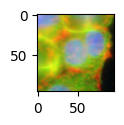

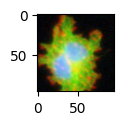

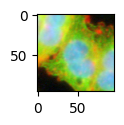

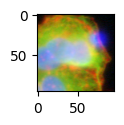

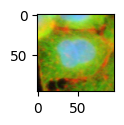

30.0


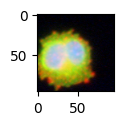

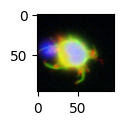

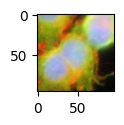

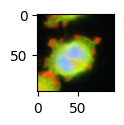

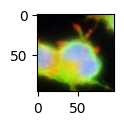

Step 0


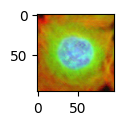

Step 1


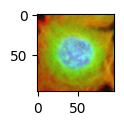

Step 2


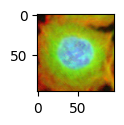

Step 3


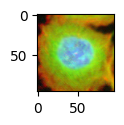

Step 4


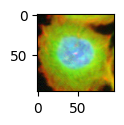

Step 5


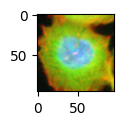

Step 6


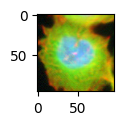

Step 7


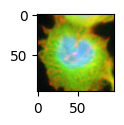

Step 8


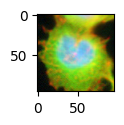

Step 9


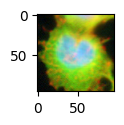

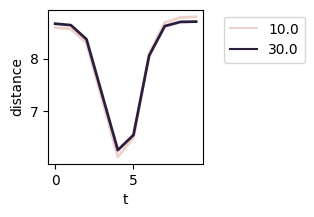

In [13]:
weeks_cyto = list(np.unique([week.split("_")[0] for week in data_index.loc[data_index.CPD_NAME=="cytochalasin B"].BATCH]))

images_dosages_cyto, images_controls_cyto, style_controls_cyto = measure_dose_correlation_curves(data_index, 
                                                                                            dataloader, 
                                                                                            "cytochalasin B", 
                                                                                            weeks_cyto, 
                                                                                            solver)

generated_interpolations_cyto = interpolate_and_measure_distance(solver, 
                                                                 images_controls_cyto[:64], 
                                                                 style_controls_cyto[:64],
                                                                 dataloader, 
                                                                 "cytochalasin B", 
                                                                 args)

for id in images_dosages_cyto:
    print(id)
    for i, im in enumerate(images_dosages_cyto[id]):
        im_np = t2np(im)
        plt.figure(figsize=(1,1))
        plt.imshow(im_np)
        plt.show()
        if i == 4:
            break

for id in generated_interpolations_cyto:
    print(f"Step {id}")
    for im in generated_interpolations_cyto[id]:
        im_np = t2np(im)
        plt.figure(figsize=(1,1))
        plt.imshow(im_np)
        plt.show()
        break

to_plot_df_cyto = compute_distances_to_dosages(images_dosages_cyto, generated_interpolations_cyto, solver)

plt.figure(figsize=(2,2))
sns.lineplot(data=to_plot_df_cyto, x="t", y="distance",hue="dosages", linewidth=2)
plt.legend(bbox_to_anchor=(1.7, 1))
plt.show()

**Nocodazole**

100%|██████████| 194/194 [00:21<00:00,  8.93it/s]


1.0


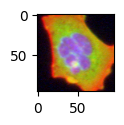

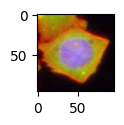

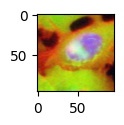

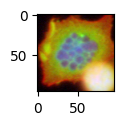

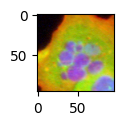

3.0


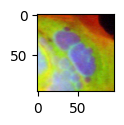

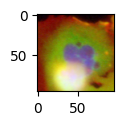

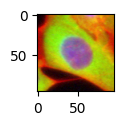

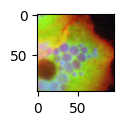

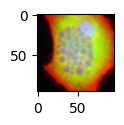

Step 0


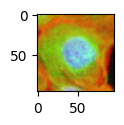

Step 1


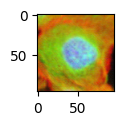

Step 2


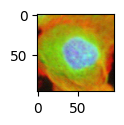

Step 3


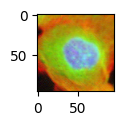

Step 4


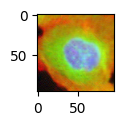

Step 5


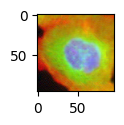

Step 6


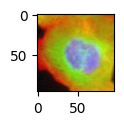

Step 7


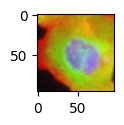

Step 8


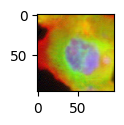

Step 9


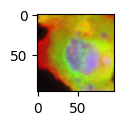

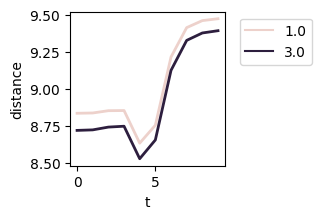

In [14]:
weeks_noco = list(np.unique([week.split("_")[0] for week in data_index.loc[data_index.CPD_NAME=="nocodazole"].BATCH]))

images_dosages_noco, images_controls_noco, style_controls_noco = measure_dose_correlation_curves(data_index, 
                                                                                            dataloader, 
                                                                                            "nocodazole", 
                                                                                            weeks_noco, 
                                                                                            solver)

generated_interpolations_noco = interpolate_and_measure_distance(solver, 
                                                                 images_controls_noco[:64], 
                                                                 style_controls_noco[:64],
                                                                 dataloader, 
                                                                 "nocodazole", 
                                                                 args)

for id in images_dosages_noco:
    print(id)
    for i, im in enumerate(images_dosages_noco[id]):
        im_np = t2np(im)
        plt.figure(figsize=(1,1))
        plt.imshow(im_np)
        plt.show()
        if i == 4:
            break

for id in generated_interpolations_noco:
    print(f"Step {id}")
    for im in generated_interpolations_noco[id]:
        im_np = t2np(im)
        plt.figure(figsize=(1,1))
        plt.imshow(im_np)
        plt.show()
        break

to_plot_df_noco = compute_distances_to_dosages(images_dosages_noco, generated_interpolations_noco, solver)

plt.figure(figsize=(2,2))
sns.lineplot(data=to_plot_df_noco, x="t", y="distance",hue="dosages", linewidth=2)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

AZ258

100%|██████████| 194/194 [00:19<00:00, 10.07it/s]


Step 0


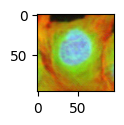

Step 1


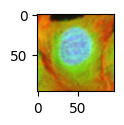

Step 2


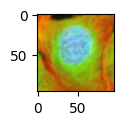

Step 3


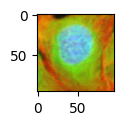

Step 4


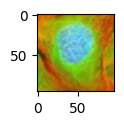

Step 5


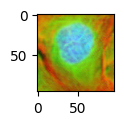

Step 6


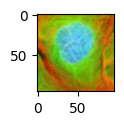

Step 7


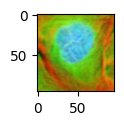

Step 8


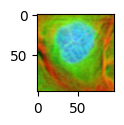

Step 9


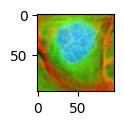

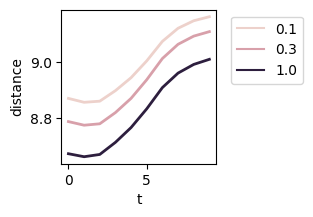

In [15]:
weeks_AZ258 = list(np.unique([week.split("_")[0] for week in data_index.loc[data_index.CPD_NAME=="AZ258"].BATCH]))

images_dosages_AZ258, images_controls_AZ258, style_controls_AZ258 = measure_dose_correlation_curves(data_index, 
                                                                                            dataloader, 
                                                                                            "AZ258", 
                                                                                            weeks_AZ258, 
                                                                                            solver)

generated_interpolations_AZ258 = interpolate_and_measure_distance(solver, 
                                                                  images_controls_AZ258[:64], 
                                                                  style_controls_AZ258[:64],
                                                                  dataloader, 
                                                                  "AZ258", 
                                                                  args)
for id in generated_interpolations_AZ258:
    print(f"Step {id}")
    for im in generated_interpolations_AZ258[id]:
        im_np = t2np(im)
        plt.figure(figsize=(1,1))
        plt.imshow(im_np)
        plt.show()
        break

to_plot_df_AZ258 = compute_distances_to_dosages(images_dosages_AZ258, generated_interpolations_AZ258, solver)

plt.figure(figsize=(2,2))
sns.lineplot(data=to_plot_df_AZ258, x="t", y="distance",hue="dosages", linewidth=2)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

taxol

100%|██████████| 194/194 [00:17<00:00, 11.06it/s]


Step 0


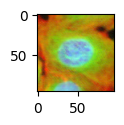

Step 1


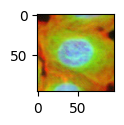

Step 2


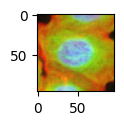

Step 3


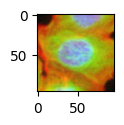

Step 4


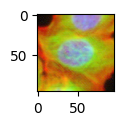

Step 5


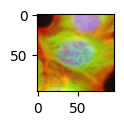

Step 6


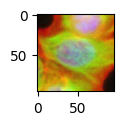

Step 7


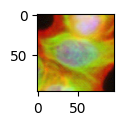

Step 8


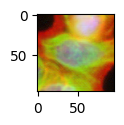

Step 9


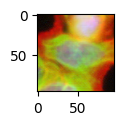

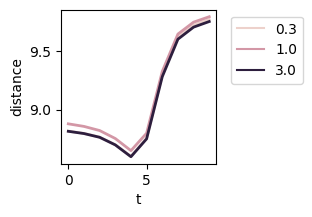

In [16]:
weeks_taxol = list(np.unique([week.split("_")[0] for week in data_index.loc[data_index.CPD_NAME=="taxol"].BATCH]))

images_dosages_taxol, images_controls_taxol, style_controls_taxol = measure_dose_correlation_curves(data_index, 
                                                                                            dataloader, 
                                                                                            "taxol", 
                                                                                            weeks_taxol, 
                                                                                            solver)

generated_interpolations_taxol = interpolate_and_measure_distance(solver, 
                                                                 images_controls_taxol[:64], 
                                                                 style_controls_taxol[:64],
                                                                 dataloader, 
                                                                 "taxol", 
                                                                 args)

for id in generated_interpolations_taxol:
    print(f"Step {id}")
    for im in generated_interpolations_taxol[id]:
        im_np = t2np(im)
        plt.figure(figsize=(1,1))
        plt.imshow(im_np)
        plt.show()
        break

to_plot_df_taxol = compute_distances_to_dosages(images_dosages_taxol, generated_interpolations_taxol, solver)

plt.figure(figsize=(2,2))
sns.lineplot(data=to_plot_df_taxol, x="t", y="distance",hue="dosages", linewidth=2)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

AZ138

100%|██████████| 194/194 [00:16<00:00, 11.76it/s]


Step 0


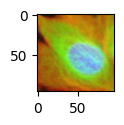

Step 1


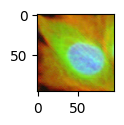

Step 2


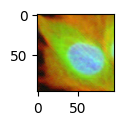

Step 3


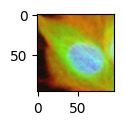

Step 4


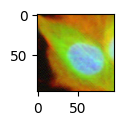

Step 5


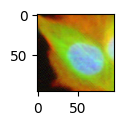

Step 6


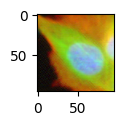

Step 7


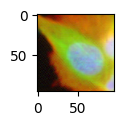

Step 8


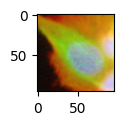

Step 9


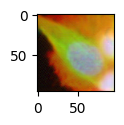

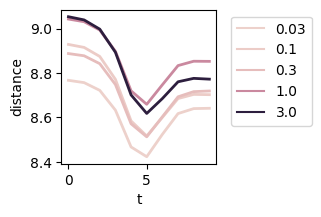

In [17]:
weeks_AZ138 = list(np.unique([week.split("_")[0] for week in data_index.loc[data_index.CPD_NAME=="AZ138"].BATCH]))

images_dosages_AZ138, images_controls_AZ138, style_controls_AZ138 = measure_dose_correlation_curves(data_index, 
                                                                                            dataloader, 
                                                                                            "AZ138", 
                                                                                            weeks_AZ138, 
                                                                                            solver)

generated_interpolations_AZ138 = interpolate_and_measure_distance(solver, 
                                                                 images_controls_AZ138[:64], 
                                                                 style_controls_AZ138[:64],
                                                                 dataloader, 
                                                                 "AZ138", 
                                                                 args)

for id in generated_interpolations_AZ138:
    print(f"Step {id}")
    for im in generated_interpolations_AZ138[id]:
        im_np = t2np(im)
        plt.figure(figsize=(1,1))
        plt.imshow(im_np)
        plt.show()
        break

to_plot_df_AZ138 = compute_distances_to_dosages(images_dosages_AZ138, generated_interpolations_AZ138, solver)

plt.figure(figsize=(2,2))
sns.lineplot(data=to_plot_df_AZ138, x="t", y="distance",hue="dosages", linewidth=2)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

mevinolin/lovastatin

100%|██████████| 194/194 [00:14<00:00, 12.94it/s]


Step 0


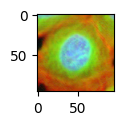

Step 1


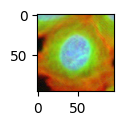

Step 2


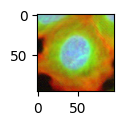

Step 3


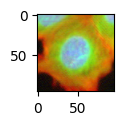

Step 4


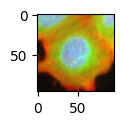

Step 5


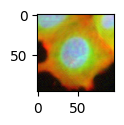

Step 6


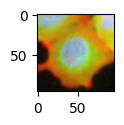

Step 7


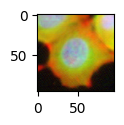

Step 8


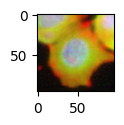

Step 9


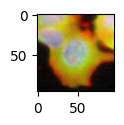

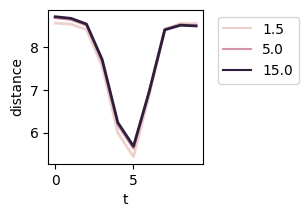

In [18]:
weeks_mevi = list(np.unique([week.split("_")[0] for week in data_index.loc[data_index.CPD_NAME=="mevinolin/lovastatin"].BATCH]))

images_dosages_mevi, images_controls_mevi, style_controls_mevi = measure_dose_correlation_curves(data_index, 
                                                                                            dataloader, 
                                                                                            "mevinolin/lovastatin", 
                                                                                            weeks_mevi, 
                                                                                            solver)

generated_interpolations_mevi = interpolate_and_measure_distance(solver, 
                                                                 images_controls_mevi[:64], 
                                                                 style_controls_mevi[:64],
                                                                 dataloader, 
                                                                 "mevinolin/lovastatin", 
                                                                 args)

for id in generated_interpolations_mevi:
    print(f"Step {id}")
    for im in generated_interpolations_mevi[id]:
        im_np = t2np(im)
        plt.figure(figsize=(1,1))
        plt.imshow(im_np)
        plt.show()
        break

to_plot_df_mevi = compute_distances_to_dosages(images_dosages_mevi, generated_interpolations_mevi, solver)

plt.figure(figsize=(2,2))
sns.lineplot(data=to_plot_df_mevi, x="t", y="distance",hue="dosages", linewidth=2)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

mitomycin C 

100%|██████████| 194/194 [00:14<00:00, 13.35it/s]


Step 0


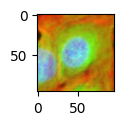

Step 1


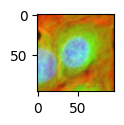

Step 2


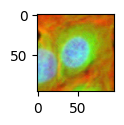

Step 3


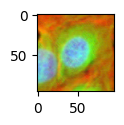

Step 4


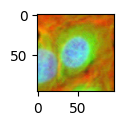

Step 5


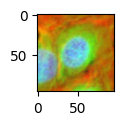

Step 6


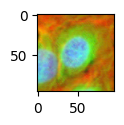

Step 7


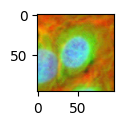

Step 8


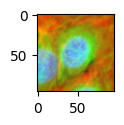

Step 9


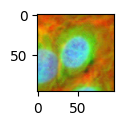

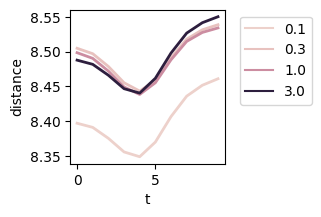

In [19]:
weeks_mitomy = list(np.unique([week.split("_")[0] for week in data_index.loc[data_index.CPD_NAME=="mitomycin C"].BATCH]))

images_dosages_mitomy, images_controls_mitomy, style_controls_mitomy = measure_dose_correlation_curves(data_index, 
                                                                                                        dataloader, 
                                                                                                        "mitomycin C", 
                                                                                                        weeks_mitomy, 
                                                                                                        solver)

generated_interpolations_mitomy = interpolate_and_measure_distance(solver, 
                                                                 images_controls_mitomy[:64], 
                                                                 style_controls_mitomy[:64],
                                                                 dataloader, 
                                                                 "mitomycin C", 
                                                                 args)

for id in generated_interpolations_mitomy:
    print(f"Step {id}")
    for im in generated_interpolations_mitomy[id]:
        im_np = t2np(im)
        plt.figure(figsize=(1,1))
        plt.imshow(im_np)
        plt.show()
        break

to_plot_df_mitomy = compute_distances_to_dosages(images_dosages_mitomy, generated_interpolations_mitomy, solver)

plt.figure(figsize=(2,2))
sns.lineplot(data=to_plot_df_mitomy, x="t", y="distance",hue="dosages", linewidth=2)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

mitoxantrone

100%|██████████| 194/194 [00:13<00:00, 14.13it/s]


Step 0


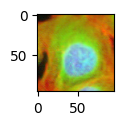

Step 1


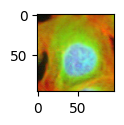

Step 2


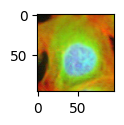

Step 3


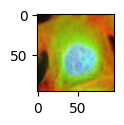

Step 4


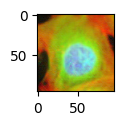

Step 5


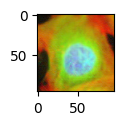

Step 6


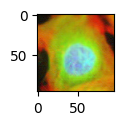

Step 7


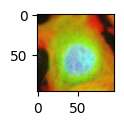

Step 8


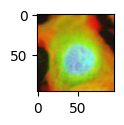

Step 9


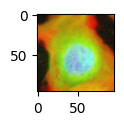

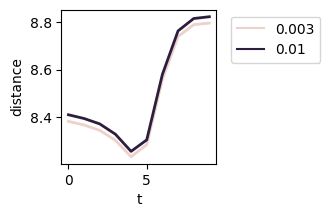

In [20]:
weeks_mitox = list(np.unique([week.split("_")[0] for week in data_index.loc[data_index.CPD_NAME=="mitoxantrone"].BATCH]))

images_dosages_mitox, images_controls_mitox, style_controls_mitox = measure_dose_correlation_curves(data_index, 
                                                                                                        dataloader, 
                                                                                                        "mitoxantrone", 
                                                                                                        weeks_mitox, 
                                                                                                        solver)

generated_interpolations_mitox = interpolate_and_measure_distance(solver, 
                                                                 images_controls_mitox[:64], 
                                                                 style_controls_mitox[:64],
                                                                 dataloader, 
                                                                 "mitoxantrone", 
                                                                 args)

for id in generated_interpolations_mitox:
    print(f"Step {id}")
    for im in generated_interpolations_mitox[id]:
        im_np = t2np(im)
        plt.figure(figsize=(1,1))
        plt.imshow(im_np)
        plt.show()
        break

to_plot_df_mitox = compute_distances_to_dosages(images_dosages_mitox, generated_interpolations_mitox, solver)

plt.figure(figsize=(2,2))
sns.lineplot(data=to_plot_df_mitox, x="t", y="distance",hue="dosages", linewidth=2)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

protease inhibitor I

100%|██████████| 194/194 [00:13<00:00, 14.77it/s]


Step 0


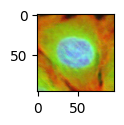

Step 1


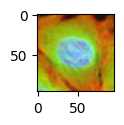

Step 2


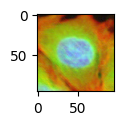

Step 3


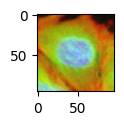

Step 4


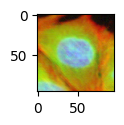

Step 5


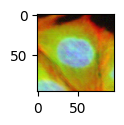

Step 6


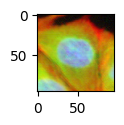

Step 7


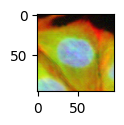

Step 8


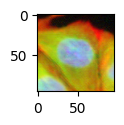

Step 9


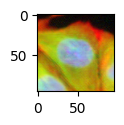

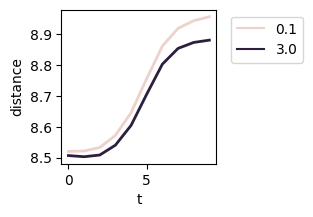

In [21]:
weeks_prote = list(np.unique([week.split("_")[0] for week in data_index.loc[data_index.CPD_NAME=="proteasome inhibitor I"].BATCH]))

images_dosages_prote, images_controls_prote, style_controls_prote = measure_dose_correlation_curves(data_index, 
                                                                                                        dataloader, 
                                                                                                        "proteasome inhibitor I", 
                                                                                                        weeks_prote, 
                                                                                                        solver)

generated_interpolations_prote = interpolate_and_measure_distance(solver, 
                                                                 images_controls_prote[:64], 
                                                                 style_controls_prote[:64],
                                                                 dataloader, 
                                                                 "proteasome inhibitor I", 
                                                                 args)

for id in generated_interpolations_prote:
    print(f"Step {id}")
    for im in generated_interpolations_prote[id]:
        im_np = t2np(im)
        plt.figure(figsize=(1,1))
        plt.imshow(im_np)
        plt.show()
        break

to_plot_df_prote = compute_distances_to_dosages(images_dosages_prote, generated_interpolations_prote, solver)

plt.figure(figsize=(2,2))
sns.lineplot(data=to_plot_df_prote, x="t", y="distance",hue="dosages", linewidth=2)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

vincristine

100%|██████████| 194/194 [00:12<00:00, 15.46it/s]


Step 0


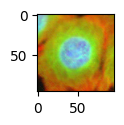

Step 1


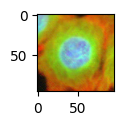

Step 2


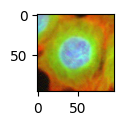

Step 3


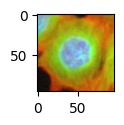

Step 4


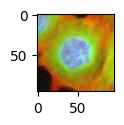

Step 5


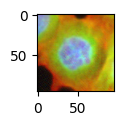

Step 6


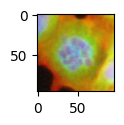

Step 7


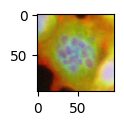

Step 8


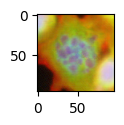

Step 9


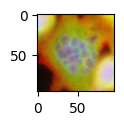

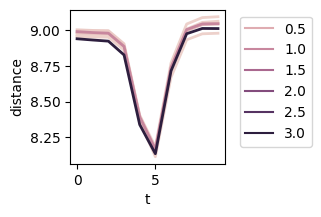

In [22]:
weeks_vincristine = list(np.unique([week.split("_")[0] for week in data_index.loc[data_index.CPD_NAME=="vincristine"].BATCH]))

images_dosages_vincristine, images_controls_vincristine, style_controls_vincristine = measure_dose_correlation_curves(data_index, 
                                                                                                        dataloader, 
                                                                                                        "vincristine", 
                                                                                                        weeks_vincristine, 
                                                                                                        solver)

generated_interpolations_vincristine = interpolate_and_measure_distance(solver, 
                                                                 images_controls_vincristine[:64], 
                                                                 style_controls_vincristine[:64],
                                                                 dataloader, 
                                                                 "vincristine", 
                                                                 args)

for id in generated_interpolations_vincristine:
    print(f"Step {id}")
    for im in generated_interpolations_vincristine[id]:
        im_np = t2np(im)
        plt.figure(figsize=(1,1))
        plt.imshow(im_np)
        plt.show()
        break

to_plot_df_vincristine = compute_distances_to_dosages(images_dosages_vincristine, generated_interpolations_vincristine, solver)

plt.figure(figsize=(2,2))
sns.lineplot(data=to_plot_df_vincristine, x="t", y="distance",hue="dosages", linewidth=2)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

demecolcine

100%|██████████| 194/194 [00:11<00:00, 17.00it/s]


Step 0


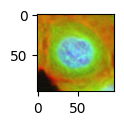

Step 1


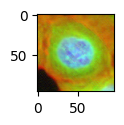

Step 2


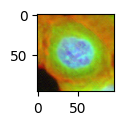

Step 3


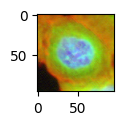

Step 4


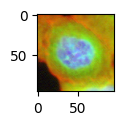

Step 5


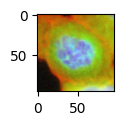

Step 6


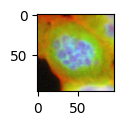

Step 7


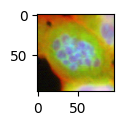

Step 8


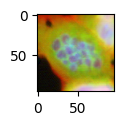

Step 9


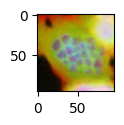

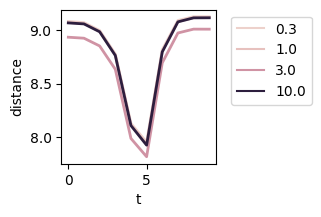

In [23]:
weeks_demecolcine = list(np.unique([week.split("_")[0] for week in data_index.loc[data_index.CPD_NAME=="demecolcine"].BATCH]))

images_dosages_demecolcine, images_controls_demecolcine, style_controls_demecolcine = measure_dose_correlation_curves(data_index, 
                                                                                                        dataloader, 
                                                                                                        "demecolcine", 
                                                                                                        weeks_demecolcine,
                                                                                                        solver)

generated_interpolations_demecolcine = interpolate_and_measure_distance(solver, 
                                                                 images_controls_demecolcine[:64], 
                                                                 style_controls_demecolcine[:64],
                                                                 dataloader, 
                                                                 "demecolcine", 
                                                                 args)

for id in generated_interpolations_demecolcine:
    print(f"Step {id}")
    for im in generated_interpolations_demecolcine[id]:
        im_np = t2np(im)
        plt.figure(figsize=(1,1))
        plt.imshow(im_np)
        plt.show()
        break

to_plot_df_demecolcine = compute_distances_to_dosages(images_dosages_demecolcine, generated_interpolations_demecolcine, solver)

plt.figure(figsize=(2,2))
sns.lineplot(data=to_plot_df_demecolcine, x="t", y="distance",hue="dosages", linewidth=2)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()

# Do analyis for Cytochalasin B and nocodazole if they are different in different contexts

In [70]:
from cellpose import models, utils
from skimage.feature import graycomatrix, graycoprops

from skimage.measure import regionprops, regionprops_table

CHANNELS = {0: "actin", 
            1: "tubulin", 
            2: "nucleus"}

def compute_texture_features(image):
    """
    Compute texture features using GLCM (Gray-Level Co-occurrence Matrix).

    Parameters:
    - image: grayscale image.

    Returns:
    - texture_features: dictionary containing texture features.
    """
    # Compute GLCM
    image_uint = (image*255.).astype(np.uint8)
    # Compute texture properties from GLCM
    texture_props = ['contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation']
    texture_features = {}
    for ch in range(3):
        distances = [1]
        angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
        glcm = graycomatrix(image_uint[:, :, ch], distances=distances, angles=angles, levels=256, symmetric=True, normed=True)

        for prop in texture_props:
            texture_features[prop+"_"+CHANNELS[ch]] = graycoprops(glcm, prop).ravel()[0]
    
    return texture_features

def cellpose_segmentation(images):
    """
    Perform Cellpose segmentation on a batch of images and measure all available region properties.

    Parameters:
    - images: numpy array of shape (N, H, W) containing N images.

    Returns:
    - region_props: a table of region properties for each segmented region.
    """
    # Define Cellpose model for 2D images
    model = models.Cellpose(gpu=True, model_type='cyto')  # gpu=True if you have GPU support

    # Results for Regionprops and texture (per channel)
    region_props_res = {}
    texture_features_res = {}
        
    # Process each image in the batch
    for i in tqdm(range(len(images))):
        image = images[i]
        for ch in range(3):
            if CHANNELS[ch] == "nucleus":
                # Segment the cells
                masks, flows, styles, diams = model.eval(image[:,:,ch], diameter=None, channels=[0,0])
            else:
                masks = np.ones_like(image[:,:,0])
            
            # Get region properties
            props = regionprops_table(masks.astype(int), image[:,:,ch], properties=('area', 
                                                                                    'eccentricity', 
                                                                                    'intensity_max', 
                                                                                    'intensity_mean', 
                                                                                    'intensity_min',
                                                                                    'label',
                                                                                    'perimeter', 
                                                                                    'solidity'))
            for key in props:
                props_mean = np.mean(props[key])
                key = key+"_"+CHANNELS[ch]
                if key not in region_props_res:
                    region_props_res[key] = np.array([props_mean])
                else:
                    region_props_res[key] = np.concatenate([region_props_res[key], np.array([props_mean])])

        # Compute texture features
        texture_features = compute_texture_features(image)
        for key in texture_features:
            if key not in texture_features_res:
                texture_features_res[key] = np.array([texture_features[key]])
            else:
                texture_features_res[key] = np.concatenate([texture_features_res[key], np.array([texture_features[key]])])
                
    return region_props_res, texture_features_res

## Compute the features for all the images

### Nocodazole

Real dosages

In [71]:
dose_shape_features_noco = {}
dose_texture_features_noco = {}

interp_shape_features_noco = {}
interp_texture_features_noco = {}

for d in images_dosages_noco:
    features_d = cellpose_segmentation(t2np(images_dosages_noco[d], batch_dim=True))
    dose_shape_features_noco[d] = features_d[0]
    dose_texture_features_noco[d] = features_d[1]

for id in generated_interpolations_noco:
    features_id = cellpose_segmentation(t2np(generated_interpolations_noco[id], batch_dim=True))
    interp_shape_features_noco[id] = features_id[0]
    interp_texture_features_noco[id] = features_id[1]

 77%|███████▋  | 50/65 [00:52<00:16,  1.08s/it]/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 64/64 [01:05<00:00,  1.03s/it]


**Check the features of real dosage images**

In [72]:
print(pd.DataFrame(dose_shape_features_noco[1.0]).mean(0))
print()
print(pd.DataFrame(dose_shape_features_noco[3.0]).mean(0))
print()
print(pd.DataFrame(dose_texture_features_noco[1.0]).mean(0))
print()
print(pd.DataFrame(dose_texture_features_noco[3.0]).mean(0))
print()

area_actin                9216.000000
eccentricity_actin           0.000000
intensity_max_actin          1.000000
intensity_mean_actin         0.528692
intensity_min_actin          0.000891
label_actin                  1.000000
perimeter_actin            380.000000
solidity_actin               1.000000
area_tubulin              9216.000000
eccentricity_tubulin         0.000000
intensity_max_tubulin        1.000000
intensity_mean_tubulin       0.442497
intensity_min_tubulin        0.000446
label_tubulin                1.000000
perimeter_tubulin          380.000000
solidity_tubulin             1.000000
area_nucleus               906.135658
eccentricity_nucleus         0.681478
intensity_max_nucleus        0.874835
intensity_mean_nucleus       0.603143
intensity_min_nucleus        0.162745
label_nucleus                2.540984
perimeter_nucleus          109.483397
solidity_nucleus             0.951000
dtype: float64

area_actin                9216.000000
eccentricity_actin           0.000

In [73]:
print(pd.DataFrame(interp_shape_features_noco[0]).mean(0))
print()
print(pd.DataFrame(interp_shape_features_noco[9]).mean(0))
print()
print(pd.DataFrame(interp_texture_features_noco[0]).mean(0))
print()
print(pd.DataFrame(interp_texture_features_noco[9]).mean(0))

area_actin                9216.000000
eccentricity_actin           0.000000
intensity_max_actin          0.949958
intensity_mean_actin         0.607126
intensity_min_actin          0.056250
label_actin                  1.000000
perimeter_actin            380.000000
solidity_actin               1.000000
area_tubulin              9216.000000
eccentricity_tubulin         0.000000
intensity_max_tubulin        0.996191
intensity_mean_tubulin       0.565401
intensity_min_tubulin        0.023070
label_tubulin                1.000000
perimeter_tubulin          380.000000
solidity_tubulin             1.000000
area_nucleus              1202.820312
eccentricity_nucleus         0.624082
intensity_max_nucleus        0.961331
intensity_mean_nucleus       0.687653
intensity_min_nucleus        0.163534
label_nucleus                1.343750
perimeter_nucleus          125.263173
solidity_nucleus             0.974534
dtype: float64

area_actin                9216.000000
eccentricity_actin           0.000

### Cytochalasin B

In [74]:
dose_shape_features_cyto = {}
dose_texture_features_cyto = {}

interp_shape_features_cyto = {}
interp_texture_features_cyto = {}

for d in images_dosages_cyto:
    features_d = cellpose_segmentation(t2np(images_dosages_cyto[d], batch_dim=True))
    dose_shape_features_cyto[d] = features_d[0]
    dose_texture_features_cyto[d] = features_d[1]

for id in generated_interpolations_cyto:
    features_id = cellpose_segmentation(t2np(generated_interpolations_cyto[id], batch_dim=True))
    interp_shape_features_cyto[id] = features_id[0]
    interp_texture_features_cyto[id] = features_id[1]

100%|██████████| 64/64 [01:10<00:00,  1.10s/it]


**Check the features of real dosage images**

In [75]:
print(pd.DataFrame(dose_shape_features_cyto[10.0]).mean(0))
print()
print(pd.DataFrame(dose_shape_features_cyto[30.0]).mean(0))
print()
print(pd.DataFrame(dose_texture_features_cyto[10.0]).mean(0))
print()
print(pd.DataFrame(dose_texture_features_cyto[30.0]).mean(0))

area_actin                9216.000000
eccentricity_actin           0.000000
intensity_max_actin          1.000000
intensity_mean_actin         0.401006
intensity_min_actin          0.000206
label_actin                  1.000000
perimeter_actin            380.000000
solidity_actin               1.000000
area_tubulin              9216.000000
eccentricity_tubulin         0.000000
intensity_max_tubulin        1.000000
intensity_mean_tubulin       0.472529
intensity_min_tubulin        0.000653
label_tubulin                1.000000
perimeter_tubulin          380.000000
solidity_tubulin             1.000000
area_nucleus               723.597754
eccentricity_nucleus         0.664030
intensity_max_nucleus        0.934449
intensity_mean_nucleus       0.662001
intensity_min_nucleus        0.185256
label_nucleus                2.122642
perimeter_nucleus          100.612211
solidity_nucleus             0.964082
dtype: float64

area_actin                9216.000000
eccentricity_actin           0.000

In [76]:
print(pd.DataFrame(interp_shape_features_cyto[0]).mean(0))
print()
print(pd.DataFrame(interp_shape_features_cyto[9]).mean(0))
print()
print(pd.DataFrame(interp_texture_features_cyto[0]).mean(0))
print()
print(pd.DataFrame(interp_texture_features_cyto[9]).mean(0))

area_actin                9216.000000
eccentricity_actin           0.000000
intensity_max_actin          0.952505
intensity_mean_actin         0.607622
intensity_min_actin          0.057971
label_actin                  1.000000
perimeter_actin            380.000000
solidity_actin               1.000000
area_tubulin              9216.000000
eccentricity_tubulin         0.000000
intensity_max_tubulin        0.996044
intensity_mean_tubulin       0.565709
intensity_min_tubulin        0.025978
label_tubulin                1.000000
perimeter_tubulin          380.000000
solidity_tubulin             1.000000
area_nucleus              1094.154948
eccentricity_nucleus         0.656597
intensity_max_nucleus        0.951187
intensity_mean_nucleus       0.683176
intensity_min_nucleus        0.171640
label_nucleus                1.453125
perimeter_nucleus          120.479830
solidity_nucleus             0.971856
dtype: float64

area_actin                9216.000000
eccentricity_actin           0.000

### Taxol

In [77]:
dose_shape_features_taxol = {}
dose_texture_features_taxol = {}

interp_shape_features_taxol = {}
interp_texture_features_taxol = {}

for d in images_dosages_taxol:
    features_d = cellpose_segmentation(t2np(images_dosages_taxol[d], batch_dim=True))
    dose_shape_features_taxol[d] = features_d[0]
    dose_texture_features_taxol[d] = features_d[1]

for id in generated_interpolations_taxol:
    features_id = cellpose_segmentation(t2np(generated_interpolations_taxol[id], batch_dim=True))
    interp_shape_features_taxol[id] = features_id[0]
    interp_texture_features_taxol[id] = features_id[1]

100%|██████████| 64/64 [01:06<00:00,  1.04s/it]


In [78]:
print(pd.DataFrame(dose_shape_features_taxol[0.3]).mean(0))
print()
pd.DataFrame(dose_shape_features_taxol[3]).mean(0)
print()
print(pd.DataFrame(dose_texture_features_taxol[0.3]).mean(0))
print()
print(pd.DataFrame(dose_texture_features_taxol[3]).mean(0))

area_actin                9216.000000
eccentricity_actin           0.000000
intensity_max_actin          1.000000
intensity_mean_actin         0.578829
intensity_min_actin          0.000785
label_actin                  1.000000
perimeter_actin            380.000000
solidity_actin               1.000000
area_tubulin              9216.000000
eccentricity_tubulin         0.000000
intensity_max_tubulin        1.000000
intensity_mean_tubulin       0.472139
intensity_min_tubulin        0.001047
label_tubulin                1.000000
perimeter_tubulin          380.000000
solidity_tubulin             1.000000
area_nucleus               798.277329
eccentricity_nucleus         0.704065
intensity_max_nucleus        0.849122
intensity_mean_nucleus       0.583970
intensity_min_nucleus        0.168901
label_nucleus                2.838710
perimeter_nucleus          104.410103
solidity_nucleus             0.951544
dtype: float64


contrast_actin            57.112850
dissimilarity_actin        4.759044

In [79]:
print(pd.DataFrame(interp_shape_features_taxol[0]).mean(0))
print()
print(pd.DataFrame(interp_shape_features_taxol[9]).mean(0))
print()
print(pd.DataFrame(interp_texture_features_taxol[0]).mean(0))
print()
print(pd.DataFrame(interp_texture_features_taxol[9]).mean(0))

area_actin                9216.000000
eccentricity_actin           0.000000
intensity_max_actin          0.954560
intensity_mean_actin         0.606782
intensity_min_actin          0.063695
label_actin                  1.000000
perimeter_actin            380.000000
solidity_actin               1.000000
area_tubulin              9216.000000
eccentricity_tubulin         0.000000
intensity_max_tubulin        0.995651
intensity_mean_tubulin       0.570422
intensity_min_tubulin        0.026265
label_tubulin                1.000000
perimeter_tubulin          380.000000
solidity_tubulin             1.000000
area_nucleus              1178.114583
eccentricity_nucleus         0.634860
intensity_max_nucleus        0.953554
intensity_mean_nucleus       0.684044
intensity_min_nucleus        0.171373
label_nucleus                1.390625
perimeter_nucleus          124.025125
solidity_nucleus             0.973157
dtype: float64

area_actin                9.216000e+03
eccentricity_actin        0.00000

### AZ138

In [80]:
dose_shape_features_AZ138 = {}
dose_texture_features_AZ138 = {}

interp_shape_features_AZ138 = {}
interp_texture_features_AZ138 = {}

for d in images_dosages_AZ138:
    features_d = cellpose_segmentation(t2np(images_dosages_AZ138[d], batch_dim=True))
    dose_shape_features_AZ138[d] = features_d[0]
    dose_texture_features_AZ138[d] = features_d[1]

for id in generated_interpolations_AZ138:
    features_id = cellpose_segmentation(t2np(generated_interpolations_AZ138[id], batch_dim=True))
    interp_shape_features_AZ138[id] = features_id[0]
    interp_texture_features_AZ138[id] = features_id[1]

100%|██████████| 64/64 [01:07<00:00,  1.06s/it]


In [81]:
print(pd.DataFrame(dose_shape_features_AZ138[0.03]).mean(0))
print()
print(pd.DataFrame(dose_shape_features_AZ138[3]).mean(0))
print()
print(pd.DataFrame(dose_texture_features_AZ138[0.03]).mean(0))
print()
print(pd.DataFrame(dose_texture_features_AZ138[3]).mean(0))

area_actin                9216.000000
eccentricity_actin           0.000000
intensity_max_actin          1.000000
intensity_mean_actin         0.537570
intensity_min_actin          0.000885
label_actin                  1.000000
perimeter_actin            380.000000
solidity_actin               1.000000
area_tubulin              9216.000000
eccentricity_tubulin         0.000000
intensity_max_tubulin        1.000000
intensity_mean_tubulin       0.459009
intensity_min_tubulin        0.000317
label_tubulin                1.000000
perimeter_tubulin          380.000000
solidity_tubulin             1.000000
area_nucleus               851.104405
eccentricity_nucleus         0.683889
intensity_max_nucleus        0.859648
intensity_mean_nucleus       0.591824
intensity_min_nucleus        0.182294
label_nucleus                2.512500
perimeter_nucleus          108.855234
solidity_nucleus             0.959888
dtype: float64

area_actin                9216.000000
eccentricity_actin           0.000

In [82]:
print(pd.DataFrame(interp_shape_features_AZ138[0]).mean(0))
print()
print(pd.DataFrame(interp_shape_features_AZ138[9]).mean(0))
print()
print(pd.DataFrame(interp_texture_features_AZ138[0]).mean(0))
print()
print(pd.DataFrame(interp_texture_features_AZ138[9]).mean(0))

area_actin                9216.000000
eccentricity_actin           0.000000
intensity_max_actin          0.972652
intensity_mean_actin         0.616883
intensity_min_actin          0.072382
label_actin                  1.000000
perimeter_actin            380.000000
solidity_actin               1.000000
area_tubulin              9216.000000
eccentricity_tubulin         0.000000
intensity_max_tubulin        0.996418
intensity_mean_tubulin       0.566415
intensity_min_tubulin        0.033419
label_tubulin                1.000000
perimeter_tubulin          380.000000
solidity_tubulin             1.000000
area_nucleus              1038.899740
eccentricity_nucleus         0.650200
intensity_max_nucleus        0.943963
intensity_mean_nucleus       0.679158
intensity_min_nucleus        0.171777
label_nucleus                1.531250
perimeter_nucleus          115.474707
solidity_nucleus             0.971587
dtype: float64

area_actin                9216.000000
eccentricity_actin           0.000

## AZ258

In [83]:
dose_shape_features_AZ258 = {}
dose_texture_features_AZ258 = {}

interp_shape_features_AZ258 = {}
interp_texture_features_AZ258 = {}

for d in images_dosages_AZ258:
    features_d = cellpose_segmentation(t2np(images_dosages_AZ258[d], batch_dim=True))
    dose_shape_features_AZ258[d] = features_d[0]
    dose_texture_features_AZ258[d] = features_d[1]

for id in generated_interpolations_AZ258:
    features_id = cellpose_segmentation(t2np(generated_interpolations_AZ258[id], batch_dim=True))
    interp_shape_features_AZ258[id] = features_id[0]
    interp_texture_features_AZ258[id] = features_id[1]

100%|██████████| 64/64 [01:08<00:00,  1.07s/it]


In [84]:
print(pd.DataFrame(dose_shape_features_AZ258[0.1]).mean(0))
print()
print(pd.DataFrame(dose_shape_features_AZ258[1]).mean(0))
print()
print(pd.DataFrame(dose_texture_features_AZ258[0.1]).mean(0))
print()
print(pd.DataFrame(dose_texture_features_AZ258[1]).mean(0))

area_actin                9216.000000
eccentricity_actin           0.000000
intensity_max_actin          1.000000
intensity_mean_actin         0.436722
intensity_min_actin          0.001409
label_actin                  1.000000
perimeter_actin            380.000000
solidity_actin               1.000000
area_tubulin              9216.000000
eccentricity_tubulin         0.000000
intensity_max_tubulin        1.000000
intensity_mean_tubulin       0.544317
intensity_min_tubulin        0.001018
label_tubulin                1.000000
perimeter_tubulin          380.000000
solidity_tubulin             1.000000
area_nucleus              1058.559934
eccentricity_nucleus         0.701977
intensity_max_nucleus        0.921190
intensity_mean_nucleus       0.680626
intensity_min_nucleus        0.195993
label_nucleus                2.086093
perimeter_nucleus          119.822933
solidity_nucleus             0.958327
dtype: float64

area_actin                9216.000000
eccentricity_actin           0.000

In [85]:
print(pd.DataFrame(interp_shape_features_AZ258[0]).mean(0))
print()
print(pd.DataFrame(interp_shape_features_AZ258[9]).mean(0))
print()
print(pd.DataFrame(interp_texture_features_AZ258[0]).mean(0))
print()
print(pd.DataFrame(interp_texture_features_AZ258[9]).mean(0))

area_actin                9216.000000
eccentricity_actin           0.000000
intensity_max_actin          0.956304
intensity_mean_actin         0.605622
intensity_min_actin          0.062382
label_actin                  1.000000
perimeter_actin            380.000000
solidity_actin               1.000000
area_tubulin              9216.000000
eccentricity_tubulin         0.000000
intensity_max_tubulin        0.996589
intensity_mean_tubulin       0.568817
intensity_min_tubulin        0.020303
label_tubulin                1.000000
perimeter_tubulin          380.000000
solidity_tubulin             1.000000
area_nucleus              1309.697917
eccentricity_nucleus         0.607586
intensity_max_nucleus        0.962875
intensity_mean_nucleus       0.683556
intensity_min_nucleus        0.154111
label_nucleus                1.320312
perimeter_nucleus          130.437711
solidity_nucleus             0.972873
dtype: float64

area_actin                9216.000000
eccentricity_actin           0.000

## mevinolin

In [86]:
dose_shape_features_mevin = {}
dose_texture_features_mevin = {}

interp_shape_features_mevin = {}
interp_texture_features_mevin = {}

for d in images_dosages_mevi:
    features_d = cellpose_segmentation(t2np(images_dosages_mevi[d], batch_dim=True))
    dose_shape_features_mevin[d] = features_d[0]
    dose_texture_features_mevin[d] = features_d[1]

for id in generated_interpolations_mevi:
    features_id = cellpose_segmentation(t2np(generated_interpolations_mevi[id], batch_dim=True))
    interp_shape_features_mevin[id] = features_id[0]
    interp_texture_features_mevin[id] = features_id[1]

100%|██████████| 64/64 [01:08<00:00,  1.07s/it]


In [87]:
print(pd.DataFrame(dose_shape_features_mevin[1.5]).mean(0))
print()
print(pd.DataFrame(dose_shape_features_mevin[15]).mean(0))
print()
print(pd.DataFrame(dose_texture_features_mevin[1.5]).mean(0))
print()
print(pd.DataFrame(dose_texture_features_mevin[15]).mean(0))

area_actin                9216.000000
eccentricity_actin           0.000000
intensity_max_actin          1.000000
intensity_mean_actin         0.487193
intensity_min_actin          0.000820
label_actin                  1.000000
perimeter_actin            380.000000
solidity_actin               1.000000
area_tubulin              9216.000000
eccentricity_tubulin         0.000000
intensity_max_tubulin        1.000000
intensity_mean_tubulin       0.436056
intensity_min_tubulin        0.000330
label_tubulin                1.000000
perimeter_tubulin          380.000000
solidity_tubulin             1.000000
area_nucleus               663.389868
eccentricity_nucleus         0.694579
intensity_max_nucleus        0.898873
intensity_mean_nucleus       0.651918
intensity_min_nucleus        0.194948
label_nucleus                2.500000
perimeter_nucleus           95.308462
solidity_nucleus             0.966665
dtype: float64

area_actin                9216.000000
eccentricity_actin           0.000

In [88]:
print(pd.DataFrame(interp_shape_features_mevin[0]).mean(0))
print()
print(pd.DataFrame(interp_shape_features_mevin[9]).mean(0))
print()
print(pd.DataFrame(interp_texture_features_mevin[0]).mean(0))
print()
print(pd.DataFrame(interp_texture_features_mevin[9]).mean(0))

area_actin                9216.000000
eccentricity_actin           0.000000
intensity_max_actin          0.954288
intensity_mean_actin         0.604701
intensity_min_actin          0.044034
label_actin                  1.000000
perimeter_actin            380.000000
solidity_actin               1.000000
area_tubulin              9216.000000
eccentricity_tubulin         0.000000
intensity_max_tubulin        0.997963
intensity_mean_tubulin       0.565392
intensity_min_tubulin        0.019415
label_tubulin                1.000000
perimeter_tubulin          380.000000
solidity_tubulin             1.000000
area_nucleus              1069.531250
eccentricity_nucleus         0.662503
intensity_max_nucleus        0.951408
intensity_mean_nucleus       0.677779
intensity_min_nucleus        0.163262
label_nucleus                1.460938
perimeter_nucleus          118.923219
solidity_nucleus             0.972376
dtype: float64

area_actin                9216.000000
eccentricity_actin           0.000

## mitomycin C

In [89]:
dose_shape_features_mitomy = {}
dose_texture_features_mitomy = {}

interp_shape_features_mitomy = {}
interp_texture_features_mitomy = {}

for d in images_dosages_mitomy:
    features_d = cellpose_segmentation(t2np(images_dosages_mitomy[d], batch_dim=True))
    dose_shape_features_mitomy[d] = features_d[0]
    dose_texture_features_mitomy[d] = features_d[1]

for id in generated_interpolations_mitomy:
    features_id = cellpose_segmentation(t2np(generated_interpolations_mitomy[id], batch_dim=True))
    interp_shape_features_mitomy[id] = features_id[0]
    interp_texture_features_mitomy[id] = features_id[1]

100%|██████████| 64/64 [01:05<00:00,  1.02s/it]


In [90]:
print(pd.DataFrame(dose_shape_features_mitomy[0.1]).mean(0))
print()
print(pd.DataFrame(dose_shape_features_mitomy[1]).mean(0))
print()
print(pd.DataFrame(dose_texture_features_mitomy[0.1]).mean(0))
print()
print(pd.DataFrame(dose_texture_features_mitomy[1]).mean(0))

area_actin                9216.000000
eccentricity_actin           0.000000
intensity_max_actin          1.000000
intensity_mean_actin         0.535173
intensity_min_actin          0.001293
label_actin                  1.000000
perimeter_actin            380.000000
solidity_actin               1.000000
area_tubulin              9216.000000
eccentricity_tubulin         0.000000
intensity_max_tubulin        1.000000
intensity_mean_tubulin       0.514978
intensity_min_tubulin        0.000936
label_tubulin                1.000000
perimeter_tubulin          380.000000
solidity_tubulin             1.000000
area_nucleus               960.582735
eccentricity_nucleus         0.685396
intensity_max_nucleus        0.930139
intensity_mean_nucleus       0.675231
intensity_min_nucleus        0.187243
label_nucleus                1.910180
perimeter_nucleus          113.657539
solidity_nucleus             0.971167
dtype: float64

area_actin                9216.000000
eccentricity_actin           0.000

In [91]:
print(pd.DataFrame(interp_shape_features_mitomy[0]).mean(0))
print()
print(pd.DataFrame(interp_shape_features_mitomy[9]).mean(0))
print()
print(pd.DataFrame(interp_texture_features_mitomy[0]).mean(0))
print()
print(pd.DataFrame(interp_texture_features_mitomy[9]).mean(0))

area_actin                9216.000000
eccentricity_actin           0.000000
intensity_max_actin          0.957979
intensity_mean_actin         0.605866
intensity_min_actin          0.057410
label_actin                  1.000000
perimeter_actin            380.000000
solidity_actin               1.000000
area_tubulin              9216.000000
eccentricity_tubulin         0.000000
intensity_max_tubulin        0.995478
intensity_mean_tubulin       0.566702
intensity_min_tubulin        0.019610
label_tubulin                1.000000
perimeter_tubulin          380.000000
solidity_tubulin             1.000000
area_nucleus              1093.298698
eccentricity_nucleus         0.636366
intensity_max_nucleus        0.944977
intensity_mean_nucleus       0.678852
intensity_min_nucleus        0.176512
label_nucleus                1.515625
perimeter_nucleus          117.952699
solidity_nucleus             0.972322
dtype: float64

area_actin                9216.000000
eccentricity_actin           0.000

## mitoxantrone

In [92]:
dose_shape_features_mitox = {}
dose_texture_features_mitox = {}

interp_shape_features_mitox = {}
interp_texture_features_mitox = {}

for d in images_dosages_mitox:
    features_d = cellpose_segmentation(t2np(images_dosages_mitox[d], batch_dim=True))
    dose_shape_features_mitox[d] = features_d[0]
    dose_texture_features_mitox[d] = features_d[1]

for id in generated_interpolations_mitox:
    features_id = cellpose_segmentation(t2np(generated_interpolations_mitox[id], batch_dim=True))
    interp_shape_features_mitox[id] = features_id[0]
    interp_texture_features_mitox[id] = features_id[1]

100%|██████████| 64/64 [01:04<00:00,  1.01s/it]


In [93]:
print(pd.DataFrame(dose_shape_features_mitox[0.003]).mean(0))
print()
print(pd.DataFrame(dose_shape_features_mitox[0.01]).mean(0))
print()
print(pd.DataFrame(dose_texture_features_mitox[0.003]).mean(0))
print()
print(pd.DataFrame(dose_texture_features_mitox[0.01]).mean(0))

area_actin                9216.000000
eccentricity_actin           0.000000
intensity_max_actin          1.000000
intensity_mean_actin         0.508785
intensity_min_actin          0.000960
label_actin                  1.000000
perimeter_actin            380.000000
solidity_actin               1.000000
area_tubulin              9216.000000
eccentricity_tubulin         0.000000
intensity_max_tubulin        1.000000
intensity_mean_tubulin       0.458351
intensity_min_tubulin        0.000526
label_tubulin                1.000000
perimeter_tubulin          380.000000
solidity_tubulin             1.000000
area_nucleus               899.053498
eccentricity_nucleus         0.702628
intensity_max_nucleus        0.943399
intensity_mean_nucleus       0.670205
intensity_min_nucleus        0.158423
label_nucleus                1.604938
perimeter_nucleus          111.034643
solidity_nucleus             0.972292
dtype: float64

area_actin                9216.000000
eccentricity_actin           0.000

In [94]:
print(pd.DataFrame(interp_shape_features_mitox[0]).mean(0))
print()
print(pd.DataFrame(interp_shape_features_mitox[9]).mean(0))
print()
print(pd.DataFrame(interp_texture_features_mitox[0]).mean(0))
print()
print(pd.DataFrame(interp_texture_features_mitox[9]).mean(0))

area_actin                9216.000000
eccentricity_actin           0.000000
intensity_max_actin          0.959759
intensity_mean_actin         0.608292
intensity_min_actin          0.051387
label_actin                  1.000000
perimeter_actin            380.000000
solidity_actin               1.000000
area_tubulin              9216.000000
eccentricity_tubulin         0.000000
intensity_max_tubulin        0.996389
intensity_mean_tubulin       0.567966
intensity_min_tubulin        0.019385
label_tubulin                1.000000
perimeter_tubulin          380.000000
solidity_tubulin             1.000000
area_nucleus              1180.848958
eccentricity_nucleus         0.628585
intensity_max_nucleus        0.960666
intensity_mean_nucleus       0.687955
intensity_min_nucleus        0.167880
label_nucleus                1.382812
perimeter_nucleus          124.429774
solidity_nucleus             0.972754
dtype: float64

area_actin                9216.000000
eccentricity_actin           0.000

## protease inhibitor I

In [95]:
dose_shape_features_prote = {}
dose_texture_features_prote = {}

interp_shape_features_prote = {}
interp_texture_features_prote = {}

for d in images_dosages_prote:
    features_d = cellpose_segmentation(t2np(images_dosages_prote[d], batch_dim=True))
    dose_shape_features_prote[d] = features_d[0]
    dose_texture_features_prote[d] = features_d[1]

for id in generated_interpolations_prote:
    features_id = cellpose_segmentation(t2np(generated_interpolations_prote[id], batch_dim=True))
    interp_shape_features_prote[id] = features_id[0]
    interp_texture_features_prote[id] = features_id[1]

100%|██████████| 64/64 [01:04<00:00,  1.01s/it]


In [97]:
print(pd.DataFrame(dose_shape_features_prote[0.1]).mean(0))
print()
print(pd.DataFrame(dose_shape_features_prote[3.0]).mean(0))
print()
print(pd.DataFrame(dose_texture_features_prote[0.1]).mean(0))
print()
print(pd.DataFrame(dose_texture_features_prote[3.0]).mean(0))

area_actin                9216.000000
eccentricity_actin           0.000000
intensity_max_actin          1.000000
intensity_mean_actin         0.550256
intensity_min_actin          0.000594
label_actin                  1.000000
perimeter_actin            380.000000
solidity_actin               1.000000
area_tubulin              9216.000000
eccentricity_tubulin         0.000000
intensity_max_tubulin        1.000000
intensity_mean_tubulin       0.478141
intensity_min_tubulin        0.000216
label_tubulin                1.000000
perimeter_tubulin          380.000000
solidity_tubulin             1.000000
area_nucleus               964.710937
eccentricity_nucleus         0.676707
intensity_max_nucleus        0.931541
intensity_mean_nucleus       0.667012
intensity_min_nucleus        0.192950
label_nucleus                1.884615
perimeter_nucleus          115.174473
solidity_nucleus             0.971342
dtype: float64

area_actin                9216.000000
eccentricity_actin           0.000

In [98]:
print(pd.DataFrame(interp_shape_features_prote[0]).mean(0))
print()
print(pd.DataFrame(interp_shape_features_prote[9]).mean(0))
print()
print(pd.DataFrame(interp_texture_features_prote[0]).mean(0))
print()
print(pd.DataFrame(interp_texture_features_prote[9]).mean(0))

area_actin                9216.000000
eccentricity_actin           0.000000
intensity_max_actin          0.968482
intensity_mean_actin         0.614249
intensity_min_actin          0.066683
label_actin                  1.000000
perimeter_actin            380.000000
solidity_actin               1.000000
area_tubulin              9216.000000
eccentricity_tubulin         0.000000
intensity_max_tubulin        0.996360
intensity_mean_tubulin       0.566698
intensity_min_tubulin        0.024349
label_tubulin                1.000000
perimeter_tubulin          380.000000
solidity_tubulin             1.000000
area_nucleus              1180.489583
eccentricity_nucleus         0.640980
intensity_max_nucleus        0.949315
intensity_mean_nucleus       0.677958
intensity_min_nucleus        0.163458
label_nucleus                1.437500
perimeter_nucleus          123.658697
solidity_nucleus             0.971226
dtype: float64

area_actin                9216.000000
eccentricity_actin           0.000

## vincristine

In [109]:
dose_shape_features_vincristine = {}
dose_texture_features_vincristine = {}

interp_shape_features_vincristine = {}
interp_texture_features_vincristine = {}

for d in images_dosages_vincristine:
    features_d = cellpose_segmentation(t2np(images_dosages_vincristine[d], batch_dim=True))
    dose_shape_features_vincristine[d] = features_d[0]
    dose_texture_features_vincristine[d] = features_d[1]

for id in generated_interpolations_vincristine:
    features_id = cellpose_segmentation(t2np(generated_interpolations_vincristine[id], batch_dim=True))
    interp_shape_features_vincristine[id] = features_id[0]
    interp_texture_features_vincristine[id] = features_id[1]

 17%|█▋        | 9/52 [00:09<00:45,  1.05s/it]/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 64/64 [01:04<00:00,  1.01s/it]


In [208]:
print(pd.DataFrame(dose_shape_features_vincristine[0.003]).mean(0))
print()
print(pd.DataFrame(dose_shape_features_vincristine[1.0]).mean(0))
print()
print(pd.DataFrame(dose_texture_features_vincristine[0.003]).mean(0))
print()
print(pd.DataFrame(dose_texture_features_vincristine[1.0]).mean(0))

area_actin                9216.000000
eccentricity_actin           0.000000
intensity_max_actin          1.000000
intensity_mean_actin         0.535819
intensity_min_actin          0.001080
label_actin                  1.000000
perimeter_actin            380.000000
solidity_actin               1.000000
area_tubulin              9216.000000
eccentricity_tubulin         0.000000
intensity_max_tubulin        1.000000
intensity_mean_tubulin       0.467707
intensity_min_tubulin        0.000336
label_tubulin                1.000000
perimeter_tubulin          380.000000
solidity_tubulin             1.000000
area_nucleus               542.122093
eccentricity_nucleus         0.690193
intensity_max_nucleus        0.777416
intensity_mean_nucleus       0.548948
intensity_min_nucleus        0.193474
label_nucleus                3.822368
perimeter_nucleus           85.700160
solidity_nucleus             0.944130
dtype: float64

area_actin                9216.000000
eccentricity_actin           0.000

In [111]:
print(pd.DataFrame(interp_shape_features_vincristine[0]).mean(0))
print()
print(pd.DataFrame(interp_shape_features_vincristine[9]).mean(0))
print()
print(pd.DataFrame(interp_texture_features_vincristine[0]).mean(0))
print()
print(pd.DataFrame(interp_texture_features_vincristine[9]).mean(0))

area_actin                9216.000000
eccentricity_actin           0.000000
intensity_max_actin          0.963188
intensity_mean_actin         0.608352
intensity_min_actin          0.065505
label_actin                  1.000000
perimeter_actin            380.000000
solidity_actin               1.000000
area_tubulin              9216.000000
eccentricity_tubulin         0.000000
intensity_max_tubulin        0.996798
intensity_mean_tubulin       0.567578
intensity_min_tubulin        0.024833
label_tubulin                1.000000
perimeter_tubulin          380.000000
solidity_tubulin             1.000000
area_nucleus              1128.778646
eccentricity_nucleus         0.642859
intensity_max_nucleus        0.949957
intensity_mean_nucleus       0.678429
intensity_min_nucleus        0.164487
label_nucleus                1.421875
perimeter_nucleus          121.409706
solidity_nucleus             0.973020
dtype: float64

area_actin                9216.000000
eccentricity_actin           0.000

## demecolcine

In [113]:
dose_shape_features_demecolcine = {}
dose_texture_features_demecolcine = {}

interp_shape_features_demecolcine = {}
interp_texture_features_demecolcine = {}

for d in images_dosages_demecolcine:
    features_d = cellpose_segmentation(t2np(images_dosages_demecolcine[d], batch_dim=True))
    dose_shape_features_demecolcine[d] = features_d[0]
    dose_texture_features_demecolcine[d] = features_d[1]

for id in generated_interpolations_demecolcine:
    features_id = cellpose_segmentation(t2np(generated_interpolations_demecolcine[id], batch_dim=True))
    interp_shape_features_demecolcine[id] = features_id[0]
    interp_texture_features_demecolcine[id] = features_id[1]

 31%|███       | 18/58 [00:26<01:04,  1.62s/it]/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 64/64 [01:40<00:00,  1.57s/it]


In [114]:
print(pd.DataFrame(dose_shape_features_demecolcine[0.3]).mean(0))
print()
print(pd.DataFrame(dose_shape_features_demecolcine[10.0]).mean(0))
print()
print(pd.DataFrame(dose_texture_features_demecolcine[0.3]).mean(0))
print()
print(pd.DataFrame(dose_texture_features_demecolcine[10.0]).mean(0))

area_actin                9216.000000
eccentricity_actin           0.000000
intensity_max_actin          1.000000
intensity_mean_actin         0.503726
intensity_min_actin          0.000630
label_actin                  1.000000
perimeter_actin            380.000000
solidity_actin               1.000000
area_tubulin              9216.000000
eccentricity_tubulin         0.000000
intensity_max_tubulin        1.000000
intensity_mean_tubulin       0.475077
intensity_min_tubulin        0.000528
label_tubulin                1.000000
perimeter_tubulin          380.000000
solidity_tubulin             1.000000
area_nucleus               808.765195
eccentricity_nucleus         0.675768
intensity_max_nucleus        0.841154
intensity_mean_nucleus       0.598551
intensity_min_nucleus        0.197938
label_nucleus                2.740000
perimeter_nucleus          104.418934
solidity_nucleus             0.948897
dtype: float64

area_actin                9216.000000
eccentricity_actin           0.000

In [115]:
print(pd.DataFrame(interp_shape_features_demecolcine[0]).mean(0))
print()
print(pd.DataFrame(interp_shape_features_demecolcine[9]).mean(0))
print()
print(pd.DataFrame(interp_texture_features_demecolcine[0]).mean(0))
print()
print(pd.DataFrame(interp_texture_features_demecolcine[9]).mean(0))

area_actin                9216.000000
eccentricity_actin           0.000000
intensity_max_actin          0.965056
intensity_mean_actin         0.611842
intensity_min_actin          0.060082
label_actin                  1.000000
perimeter_actin            380.000000
solidity_actin               1.000000
area_tubulin              9216.000000
eccentricity_tubulin         0.000000
intensity_max_tubulin        0.995967
intensity_mean_tubulin       0.566306
intensity_min_tubulin        0.024323
label_tubulin                1.000000
perimeter_tubulin          380.000000
solidity_tubulin             1.000000
area_nucleus              1081.015625
eccentricity_nucleus         0.639490
intensity_max_nucleus        0.952325
intensity_mean_nucleus       0.686256
intensity_min_nucleus        0.172440
label_nucleus                1.460938
perimeter_nucleus          119.962401
solidity_nucleus             0.971615
dtype: float64

area_actin                9216.000000
eccentricity_actin           0.000

## Make plots

In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def make_lineplot(dose_shape_features, interp_features, feature_to_plot, title):
    to_plot = {"t": [], 
               "value": []}
    
    for t in interp_features:
        fea = list(interp_features[t][feature_to_plot])
        to_plot["value"] += list(fea)
        to_plot["t"] += [t for _ in range(len(fea))]

    # Extract dose values and their mean feature values
    dose_marks = [(d, np.nanmean(dose_shape_features[d][feature_to_plot])) for d in dose_shape_features]
    print(dose_marks)
    
    # Sort the dose_marks list based on the dose
    dose_marks.sort(key=lambda x: x[0])
    
    # Convert dictionary to DataFrame
    df = pd.DataFrame(to_plot)

    # Create line plot
    sns.set(style="whitegrid")
    plt.figure(figsize=(3, 3))
    sns.lineplot(data=df, x="t", y="value", color='blue', linewidth=2, marker='o', markersize=8, markerfacecolor='blue', markeredgewidth=2, markeredgecolor='black')
    
    # Create a continuous color palette for dose values
    dose_palette = sns.color_palette("colorblind", n_colors=len(dose_marks))
    dose_color_map = {dose: dose_palette[i] for i, (dose, _) in enumerate(dose_marks)}
    
    for dose, mean_value in dose_marks:
        plt.axhline(y=mean_value, color=dose_color_map[dose], linestyle='--', linewidth=2, label=dose)
    
    plt.xlabel("t", fontsize=14)
    plt.ylabel("value", fontsize=14)
    plt.title(title, fontsize=16)

    # Customize legend
    plt.legend(title='Dose', loc='center left', bbox_to_anchor=(1, 0.5), fontsize=12)
    
    # Customize ticks
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    # Grid style
    plt.grid(True, linestyle='--', alpha=0.7)
    
    plt.show()

# def make_lineplot(dose_shape_features, interp_features, feature_to_plot, title, y_label):
#     to_plot = {"t": [], 
#                "value": []}
    
#     for t in interp_features:
#         fea = list(interp_features[t][feature_to_plot])
#         to_plot["value"] += list(fea)
#         to_plot["t"] += [t for _ in range(len(fea))]

#     # Calculate the mean value of the feature across all doses
#     all_doses_values = [np.nanmean(dose_shape_features[d][feature_to_plot]) for d in dose_shape_features]
#     common_y_intercept = np.nanmean(all_doses_values)
    
#     # Convert dictionary to DataFrame
#     df = pd.DataFrame(to_plot)

#     # Create line plot
#     sns.set(style="whitegrid")
#     plt.figure(figsize=(3, 3))
#     sns.lineplot(data=df, x="t", y="value", color='blue', linewidth=2, marker='o', markersize=8, markerfacecolor='blue', markeredgewidth=2, markeredgecolor='black')
    
#     # Plot the common y-intercept
#     plt.axhline(y=common_y_intercept, color='red', linestyle='--', linewidth=2)
    
#     plt.xlabel("t", fontsize=14)
#     plt.ylabel(y_label, fontsize=14)
#     plt.title(title, fontsize=16)
    
#     # Customize ticks
#     plt.xticks(fontsize=12)
#     plt.yticks(fontsize=12)
    
#     # Grid style
#     plt.grid(True, linestyle='--', alpha=0.7)
#     plt.savefig(f"/home/icb/alessandro.palma/environment/IMPA/IMPA/notebooks/cpg0000/corrections_old_paper/plots/{title}.svg",
#            dpi=300, bbox_inches='tight', format='svg')
    
#     plt.show()

## Check plots

AZ138 

In [13]:
# make_lineplot(dose_shape_features_AZ138, interp_shape_features_AZ138, "area_nucleus","AZ138 - Area nucleus")

In [14]:
# make_lineplot(dose_shape_features_AZ138, interp_shape_features_AZ138, "perimeter_nucleus","AZ138 - Perimeter nucleus")

AZ258

[(0.1, 0.4367220023807311), (1.0, 0.480978185740801), (0.3, 0.4683453070856359)]


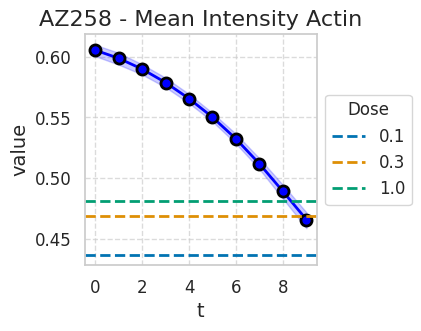

In [15]:
make_lineplot(dose_shape_features_AZ258, interp_shape_features_AZ258, "intensity_mean_actin","AZ258 - Mean Intensity Actin")

[(0.1, 119.8229331542083), (1.0, 127.94439121884643), (0.3, 125.9719292465368)]


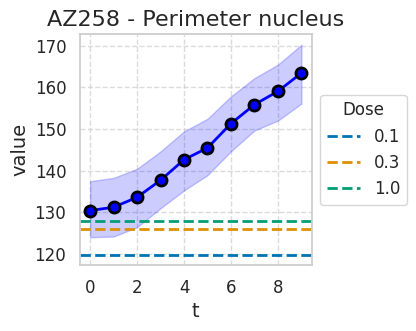

In [16]:
make_lineplot(dose_shape_features_AZ258, interp_shape_features_AZ258, "perimeter_nucleus","AZ258 - Perimeter nucleus")

Mitomycin C 

[(0.1, 113.65753898976513), (0.3, 117.10021544981512), (1.0, 117.50678695250849), (3.0, 119.66131391068275)]


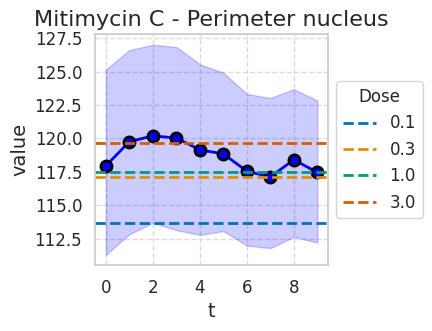

In [17]:
make_lineplot(dose_shape_features_mitomy, interp_shape_features_mitomy, "perimeter_nucleus","Mitimycin C - Perimeter nucleus")

Nocodazole

[(3.0, 106.87534750526221), (1.0, 109.48339707037351)]


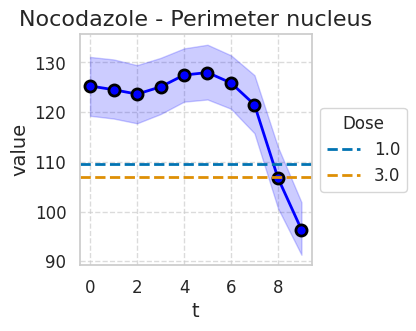

In [18]:
make_lineplot(dose_shape_features_noco, interp_shape_features_noco, "perimeter_nucleus","Nocodazole - Perimeter nucleus")

[(3.0, 840.5402059140156), (1.0, 906.1356584672158)]


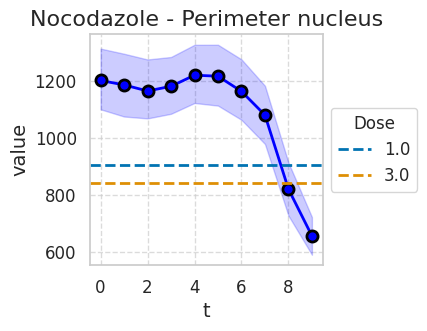

In [19]:
make_lineplot(dose_shape_features_noco, interp_shape_features_noco, "area_nucleus","Nocodazole - Perimeter nucleus")

Cytochalasin B 

In [20]:
make_lineplot(dose_texture_features_cyto, interp_texture_features_cyto, "contrast_actin","Cytochalasin B - Contrast Actin", 
             "contrast actin")

TypeError: make_lineplot() takes 4 positional arguments but 5 were given

Taxol

[(1.0, 72.97398648648932), (3.0, 76.90151746554271), (0.3, 64.67518746463166)]


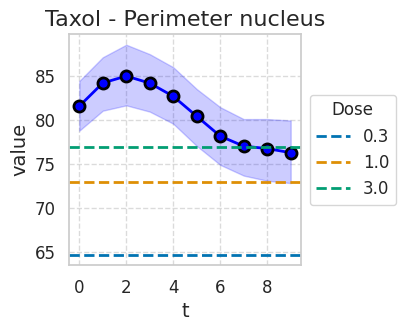

In [21]:
make_lineplot(dose_texture_features_taxol, interp_texture_features_taxol, "contrast_tubulin","Taxol - Perimeter nucleus")

Mevinolin

[(5.0, 0.6334260145704899), (1.5, 0.6519184120164977), (15.0, 0.6190986164182459)]


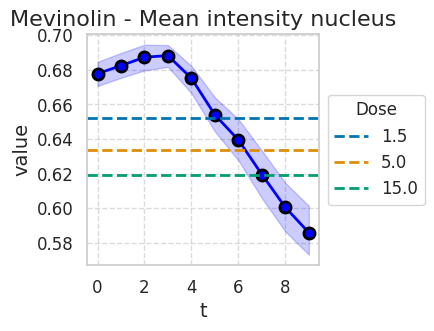

In [22]:
make_lineplot(dose_shape_features_mevin, interp_shape_features_mevin, "intensity_mean_nucleus","Mevinolin - Mean intensity nucleus")

Mitixantrone 

[(0.003, 109.41439246263977), (0.01, 106.56554855448668)]


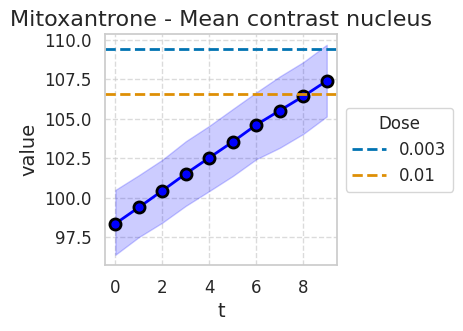

In [23]:
make_lineplot(dose_texture_features_mitox, interp_texture_features_mitox, "contrast_nucleus","Mitoxantrone - Mean contrast nucleus")

proteasome inhibitor

[(0.1, 60.444617553499995), (3.0, 72.0931397787961)]


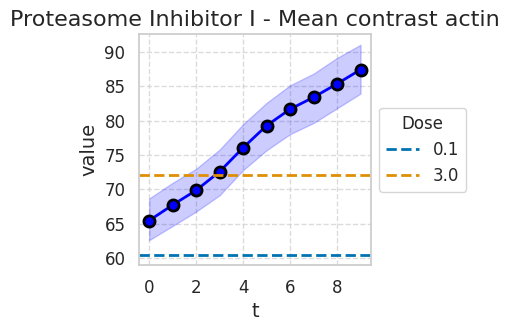

In [24]:
make_lineplot(dose_texture_features_prote, interp_texture_features_prote, "contrast_actin","Proteasome Inhibitor I - Mean contrast actin")

vincristine

In [25]:
make_lineplot(dose_shape_features_vincristine, interp_shape_features_vincristine, "area_nucleus","Vincristine - Area nucleus", 
             "area nucleus")

TypeError: make_lineplot() takes 4 positional arguments but 5 were given

demecolcine

[(0.3, 808.7651947496947), (1.0, 896.6970340332183), (3.0, 797.3707548786497), (10.0, 791.9649252672278)]


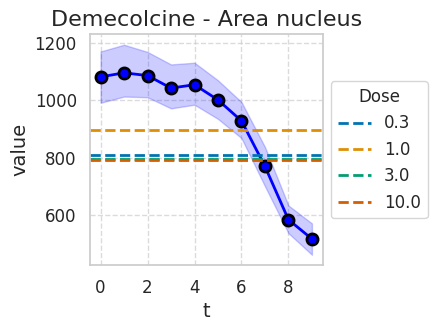

In [26]:
make_lineplot(dose_shape_features_demecolcine, interp_shape_features_demecolcine, "area_nucleus","Demecolcine - Area nucleus")

Save_stuff as pkl

In [5]:
import pickle as pkl 

In [ ]:
dose_shape_features_all = [dose_shape_features_noco, 
                           dose_shape_features_cyto, 
                           dose_shape_features_taxol, 
                           dose_shape_features_AZ258, 
                           dose_shape_features_mevin, 
                           dose_shape_features_mitomy,
                           dose_shape_features_mitox,
                           dose_shape_features_prote, 
                           dose_shape_features_vincristine,
                           dose_shape_features_demecolcine, 
                          ]

dose_texture_features_all = [dose_texture_features_noco, 
                               dose_texture_features_cyto, 
                               dose_texture_features_taxol, 
                               dose_texture_features_AZ258, 
                               dose_texture_features_mevin, 
                               dose_texture_features_mitomy,
                               dose_texture_features_mitox,
                               dose_texture_features_prote, 
                               dose_texture_features_vincristine,
                               dose_texture_features_demecolcine]

interp_shape_features_all = [interp_shape_features_noco, 
                               interp_shape_features_cyto, 
                               interp_shape_features_taxol, 
                               interp_shape_features_AZ258, 
                               interp_shape_features_mevin, 
                               interp_shape_features_mitomy,
                               interp_shape_features_mitox,
                               interp_shape_features_prote, 
                               interp_shape_features_vincristine,
                               interp_shape_features_demecolcine]

interp_texture_features_all = [interp_texture_features_noco, 
                               interp_texture_features_cyto, 
                               interp_texture_features_taxol, 
                               interp_texture_features_AZ258, 
                               interp_texture_features_mevin, 
                               interp_texture_features_mitomy,
                               interp_texture_features_mitox,
                               interp_texture_features_prote, 
                               interp_texture_features_vincristine,
                               interp_texture_features_demecolcine]

In [219]:
# import pickle as pkl

# with open("/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments_paper_correction/dose_curves/dose_shape_features_all.pkl", "wb") as file_dose_shape_features_all:
#     pkl.dump(dose_shape_features_all, file_dose_shape_features_all)

# with open("/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments_paper_correction/dose_curves/dose_texture_features_all.pkl", "wb") as file_dose_texture_features_all:
#     pkl.dump(dose_texture_features_all, file_dose_texture_features_all)

# with open("/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments_paper_correction/dose_curves/interp_shape_features_all.pkl", "wb") as file_interp_shape_features_all:
#     pkl.dump(interp_shape_features_all, file_interp_shape_features_all)

# with open("/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments_paper_correction/dose_curves/interp_texture_features_all.pkl", "wb") as file_interp_texture_features_all:
#     pkl.dump(interp_texture_features_all, file_interp_texture_features_all)

In [7]:
import pickle as pkl

with open("/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments_paper_correction/dose_curves/dose_shape_features_all.pkl", "rb") as file_dose_shape_features_all:
    dose_shape_features_all = pkl.load(file_dose_shape_features_all)

with open("/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments_paper_correction/dose_curves/dose_texture_features_all.pkl", "rb") as file_dose_texture_features_all:
    dose_texture_features_all = pkl.load(file_dose_texture_features_all)

with open("/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments_paper_correction/dose_curves/interp_shape_features_all.pkl", "rb") as file_interp_shape_features_all:
    interp_shape_features_all = pkl.load(file_interp_shape_features_all)

with open("/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments_paper_correction/dose_curves/interp_texture_features_all.pkl", "rb") as file_interp_texture_features_all:
    interp_texture_features_all = pkl.load(file_interp_texture_features_all)

In [8]:
(dose_shape_features_noco, 
 dose_shape_features_cyto, 
 dose_shape_features_taxol, 
 dose_shape_features_AZ258, 
 dose_shape_features_mevin, 
 dose_shape_features_mitomy,
 dose_shape_features_mitox,
 dose_shape_features_prote, 
 dose_shape_features_vincristine,
 dose_shape_features_demecolcine) = dose_shape_features_all

In [9]:
(dose_texture_features_noco, 
    dose_texture_features_cyto, 
    dose_texture_features_taxol, 
    dose_texture_features_AZ258, 
    dose_texture_features_mevin, 
    dose_texture_features_mitomy,
    dose_texture_features_mitox,
    dose_texture_features_prote, 
    dose_texture_features_vincristine,
    dose_texture_features_demecolcine) = dose_texture_features_all

In [10]:
(interp_shape_features_noco, 
   interp_shape_features_cyto, 
   interp_shape_features_taxol, 
   interp_shape_features_AZ258, 
   interp_shape_features_mevin, 
   interp_shape_features_mitomy,
   interp_shape_features_mitox,
   interp_shape_features_prote, 
   interp_shape_features_vincristine,
   interp_shape_features_demecolcine) = interp_shape_features_all

In [11]:
(interp_texture_features_noco, 
   interp_texture_features_cyto, 
   interp_texture_features_taxol, 
   interp_texture_features_AZ258, 
   interp_texture_features_mevin, 
   interp_texture_features_mitomy,
   interp_texture_features_mitox,
   interp_texture_features_prote, 
   interp_texture_features_vincristine,
   interp_texture_features_demecolcine) = interp_texture_features_all